In [2]:
import warnings, gc
import numpy as np 
import pandas as pd
import matplotlib.colors
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from datetime import datetime, timedelta
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error,mean_absolute_error

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler


from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance
import matplotlib.pyplot as plt

import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from codecs import raw_unicode_escape_decode




c:\Users\wianc\anaconda3\envs\MasterEnv\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
c:\Users\wianc\anaconda3\envs\MasterEnv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Business Cycles and Economic Regimes

### In this notebook we investigate methods to 
#### - Define different Economic Regimes from economic data.
#### - Define strategies to leverage from the given Regimes.
#### - Optimize the weighting of these strategies.

###### Recources are: 
###### - Framework for style investing paper:
###### - A Medium paper, found here: https://medium.com/@richardhwlin/how-does-investment-clock-work-c7d8fbbeb7bd

#### Afterwards we would like to use/develop a coincident indicator the matches the business cycles.
#### From this we would like to develop a leading indicator for the coincident indicator.

In [3]:
# In this section I reuse the code from "Economic Data Exploration" to read and prepare the economic data.


# Read in and construct the initial dataset.

def createDataset(csv):
    temp_ds = pd.read_csv(csv)
    temp_ds.date = pd.to_datetime(temp_ds.date, format="%Y/%m/%d")
    temp_ds = temp_ds.set_index('date')
    print(temp_ds.shape)
    return temp_ds

# Define folder path of source data
#folder_path = "C:/Users/Wian/Desktop/Economic Data/"
folder_path = "C:/Users/wianC/Desktop/NMRQL/Economic Data/"

# Read in description files
annual_desc = pd.read_csv(folder_path + 'annually_description_file.csv')
month_desc = pd.read_csv(folder_path + 'monthly_description_file.csv')
quarterly_desc = pd.read_csv(folder_path + 'quarterly_description_file.csv')

# Read in data files
annual_data = createDataset(folder_path + 'us_economics_annually.csv')
quarterly_data = createDataset(folder_path + 'us_economics_quarterly.csv')
monthly_data = createDataset(folder_path + 'us_economics_monthly.csv')

# Concatenate all data together (with an outer join)
concat_data = pd.concat([monthly_data, quarterly_data, annual_data], axis = 1, join='outer')

# Check that column ids (descriptions references) do not overlap between the different datasets we concatennated.
if len(concat_data.columns.unique()) < len(concat_data.columns): print("Duplicated columns present in data!")

# Check for any categorical data - The datasets are all float, hinting that there is none... Still need to verify though.
print("Dataframe unique dtypes: ", np.unique(list(concat_data.dtypes)))
print()

# Perform resampling as well as inter- and extrapolation on the dataset.
temp_ds = concat_data.resample(rule='Q', label='right').mean().interpolate('linear').ffill()


# Let's have a threshold that removes variables that do not have enough data.
# If threshold is set to 10% (0.1) then variables with more than 10% NaN values are dropped from the dataset.
def thresholdData(data_ds, threshold):

    temp_ds = data_ds.copy()
    count = 0
    for col in temp_ds.columns:
        if temp_ds[col].isna().sum()/len(temp_ds[col]) > threshold:
            temp_ds.drop(col, axis = 1, inplace=True)
            count = count + 1
    print("Performed thresholding:")
    print("Dropped signals" , count)
    print("Remaining signals: ", len(temp_ds.columns))
    print("Amount of observations: ", len(temp_ds))
    return temp_ds.dropna(axis = 0)

# Create new dataset based on threshold value
threshold = 0.01
raw_ds = thresholdData(temp_ds, threshold)

# Create description dataset based on new threshold data dataset
all_desc = pd.concat((month_desc, quarterly_desc, annual_desc))
temp_list = list()
for match in raw_ds.columns:
    temp_list.append(all_desc[all_desc['series_id'] == int(match)])
raw_desc = pd.DataFrame(np.reshape(temp_list, (len(raw_ds.columns),2)), columns=all_desc.columns)


(62, 174)
(250, 442)
(751, 429)
Dataframe unique dtypes:  [dtype('float64')]

Performed thresholding:
Dropped signals 651
Remaining signals:  394
Amount of observations:  251


In [4]:
# The medium page describes four business cycles:
# Reflation, Recovery, Overheat and Stagflation. 
# (This is different to the Framework for Style Investing paper, they have:
# Expansion, Recovery, Contraction and Slowdown as business cycles.)

# They group the following industries into the different cycles:
# Reflation — Financials, Consumer Staples, Healthcare, and Consumer Discretionary;
# Recovery — Telecom, Tech, Basic Materials, and Consumer Discretionary;
# Overheat —Industrials, Tech, Basic Materials, and Energy;
# Stagflation — Utilities, Consumer Staples, Healthcare, and Energy.

# 
#  # https://medium.com/@richardhwlin/how-does-investment-clock-work-c7d8fbbeb7bd

In [5]:
# Simple function to search for key phrase matches amongst the signals 

def SearchForMatches(searchWords, desc_df):

    temp_dict = dict()
    for i in range(len(desc_df)):
        temp_dict[i] = np.array(desc_df['description'])[i]

    temp_array = temp_dict.values()
    for word in searchWords:
        matches = [match for match in temp_array if word in match]
        print(word)
        print("There are ", len(matches), " matches for ", word, ":")

    print()
    print('Description/s:')
    print()
    targets = list()
    temp_ids = list()
    for match in matches:
        print(match)
        temp_ids.append(list(desc_df.loc[lambda desc_df: desc_df['description'] == match]['series_id'])[0])

    return temp_ids

In [6]:
# The Medium paper uses the Consumer Price Index (~Inflation) as one signal of the economies regimes 
# There are 9 matches for CPI in the dataset. I choose the most general one as our signal. 
# I convert the signal to a YoY% variable (Enables us to identify the level of change in the signal).
 
searchWords = ['Consumer Price Index']
temp_ids = SearchForMatches(searchWords, raw_desc)

CPI_data = pd.DataFrame(data = raw_ds[[str(id) for id in temp_ids if str(id) in raw_ds.columns]])


# Create description dataset based on new threshold data dataset
temp_list = list()
for match in CPI_data.columns:
    temp_list.append(all_desc[all_desc['series_id'] == int(match)])
CPI_desc = pd.DataFrame(np.reshape(temp_list, (len(CPI_data.columns),2)), columns=all_desc.columns)


index = 0
print()
print("Choosing signal", CPI_desc.iloc[index].series_id)
print(CPI_desc.iloc[index].description)
CPI = CPI_data.iloc[:,index].pct_change(4).dropna()*100

Consumer Price Index
There are  9  matches for  Consumer Price Index :

Description/s:

United States: Consumer Price Index CPI [Consumer Price Index, All items:  United States]
United States: Consumer Price Index CPI [US: CPI: All Urban Consumers (CPI-U-82/84): All Items]
United States: Prices, Consumer Price Index, CPI: All Urban Consumers, Apparel (1982-1984), SA - United States [US: CPI-U-82/84: sa: Apparel]
United States: Prices, Consumer Price Index, CPI: All Urban Consumers, All Items (1982-1984), SA - United States [US: CPI: All Urban Consumers (CPI-U-82/84): sa: All Items]
United States: Prices, Consumer Price Index, CPI: All Urban Consumers, Medical Care (1982-1984), SA - United States [US: CPI-U-82/84: sa: Medical Care (MC)]
United States: Prices, Consumer Price Index, CPI: All Urban Consumers, Transportation (1982-1984), SA - United States [US: CPI-U-82/84: sa: Transport]
United States: Consumer Price Index, Average [US: CPI: All Urban Consumers (CPI-U-82/84): All Items]
Un

In [7]:
# The Medium paper uses the Gross Domestic Product (~Growth) as one signal of the economies regimes 
# There are 25 matches for GDP in the dataset. I choose the most general one as our signal. 
# I convert the signal to a YoY% variable (Enables us to identify the level of change in the signal).

searchWords = ['Gross Domestic Product']
#searchWords = ['United States: GDP - Real (USD) [US: Gross Domestic Product (GDP): 2012p: sa]']

temp_ids = SearchForMatches(searchWords, raw_desc)

GDP_data = pd.DataFrame(data = raw_ds[[str(id) for id in temp_ids if str(id) in raw_ds.columns]])


# Create description dataset based on new threshold data dataset
temp_list = list()
for match in GDP_data.columns:
    temp_list.append(all_desc[all_desc['series_id'] == int(match)])
GDP_desc = pd.DataFrame(np.reshape(temp_list, (len(GDP_data.columns),2)), columns=all_desc.columns)

index = 9
print()
print("Choosing signal", GDP_desc.iloc[index].series_id)
print(GDP_desc.iloc[index].description)
GDP = GDP_data.iloc[:,index].pct_change(4).dropna()*100

Gross Domestic Product
There are  25  matches for  Gross Domestic Product :

Description/s:

United States: GDP (USD) [US: Gross Domestic Product (GDP): sa]
United States: GDP [US: Gross Domestic Product (GDP): sa]
United States: GDP Annual Growth Rate [US: Gross Domestic Product (GDP): sa: PCTCHG_1]
United States: GDP Annual Growth Rate [US: Gross Domestic Product (GDP): sa: PCTCHG_2]
United States: GDP Constant Prices [US: Gross Domestic Product (GDP): 2012p: sa]
United States: GDP Growth Annualized [US: Gross Domestic Product (GDP): sa: PCTCHG_3]
United States: GDP Growth Rate [US: Gross Domestic Product (GDP): sa: PCTCHG_4]
United States: GDP - Nominal [US: Gross Domestic Product (GDP): sa]
United States: GDP - Real (Growth - YoY%) [US: Gross Domestic Product (GDP): 2012p: sa: PCTCHG]
United States: GDP - Real [US: Gross Domestic Product (GDP): 2012p: sa]
United States: GDP - Real (Growth - YoY%) - Forecast [US: Gross Domestic Product (GDP): 2012p: sa: PCTCHG: Forecast original ser

<AxesSubplot:xlabel='date'>

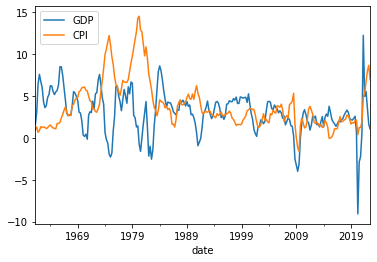

In [8]:
# Simple plot to compare the two signals.

signals = pd.DataFrame((GDP, CPI)).transpose().rename(columns = {'45999' : 'GDP', '43717' : 'CPI'})
signals.plot()

In [9]:
# Assign economic regime (Themes) according to Growth and Inflation numbers.

def InvestmentClockFixed(x,cuts={'GDP':2.5,'CPI':3}):

    x_ = x.copy().assign(Growth=None,Inflation=None,Theme=None)
    
    # define high and low growth
    x_.loc[x['GDP']<=cuts['GDP'],'Growth'] = 'low'
    x_.loc[x['GDP']>cuts['GDP'],'Growth'] = 'high'
   
    # define high and low inflation  
    x_.loc[x['CPI']<=cuts['CPI'],'Inflation'] = 'low'
    x_.loc[x['CPI']>cuts['CPI'],'Inflation'] = 'high'
   
    # define investment clock phases
    x_.loc[(x_.Growth=='low')&(x_.Inflation=='low'),'Theme'] = 'Reflection'
    x_.loc[(x_.Growth=='high')&(x_.Inflation=='low'),'Theme'] = 'Recovery'
    x_.loc[(x_.Growth=='high')&(x_.Inflation=='high'),'Theme'] = 'Overheat'
    x_.loc[(x_.Growth=='low')&(x_.Inflation=='high'),'Theme'] = 'Stagflation'

    return x_.dropna()

themes = InvestmentClockFixed(signals,cuts={'GDP':2.5,'CPI':3})
themes

,GDP,CPI,Growth,Inflation,Theme
date,,,,,
1961-06-30,1.564455,0.935270,low,low,Reflection
1961-09-30,3.009921,1.277327,high,low,Recovery
1961-12-31,6.395530,0.658376,high,low,Recovery
1962-03-31,7.567276,0.853450,high,low,Recovery
1962-06-30,6.727690,1.316752,high,low,Recovery
...,...,...,...,...,...
2021-09-30,4.946556,5.338855,high,high,Overheat
2021-12-31,5.533484,6.691792,high,high,Overheat
2022-03-31,3.527892,7.965751,high,high,Overheat


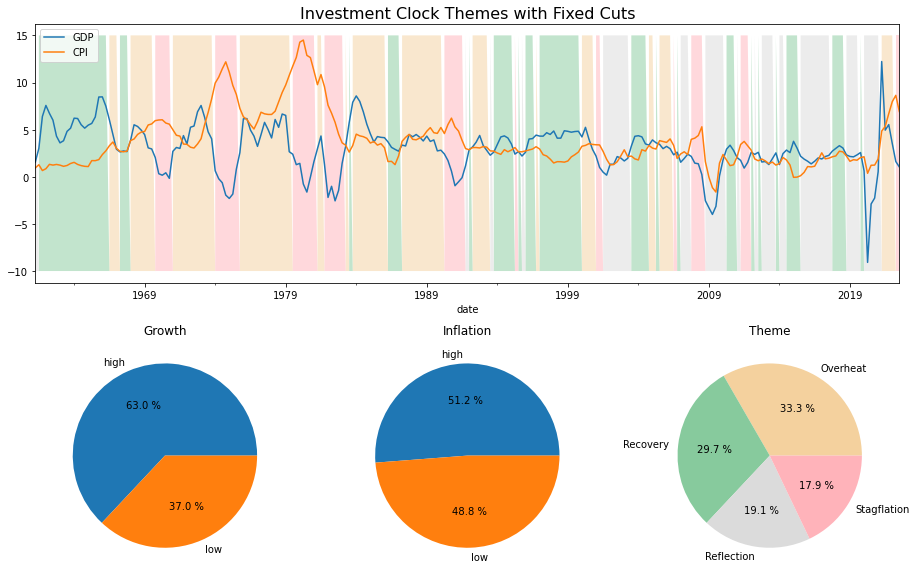

In [10]:
fig = plt.figure(figsize=(12,8))
fig.suptitle('Investment Clock Themes with Fixed Cuts',fontsize=16)
ax1 = fig.add_axes((0,0.5,1,0.45))
ax2 = fig.add_axes((0,0,0.3,0.4))
ax3 = fig.add_axes((0.35,0,0.3,0.4))
ax4 = fig.add_axes((0.7,0,0.3,0.4))
y_lim = (-10,15)
colors = dict(
  Overheat='#f4d19e',
  Recovery='#87ca9d',
  Reflection='#dbdbdb',
  Stagflation='#ffb3ba'
) 
p1 = themes[['GDP','CPI']].plot(ax=ax1)
for t in ['Overheat','Recovery','Reflection','Stagflation']:
   ax1.fill_between(
      themes.index, y_lim[0],y_lim[1], 
      where=(themes.Theme==t),
      interpolate = True,
      facecolor=colors[t], 
      alpha = 0.5
   )
growth_counts=themes.Growth.value_counts()
ax2.pie(growth_counts,autopct='%.1f %%',
        labels=growth_counts.index)
ax2.set_title('Growth')
inflation_counts=themes.Inflation.value_counts()
ax3.pie(inflation_counts,autopct='%.1f %%',
        labels=inflation_counts.index)
ax3.set_title('Inflation')
theme_counts=themes.Theme.value_counts().sort_index(ascending=True)
ax4.pie(theme_counts,autopct='%.1f %%',
        labels=theme_counts.index,colors=colors.values())
ax4.set_title('Theme')
plt.show()

### Regime Cluster Strategy and Analysis using K Nearest Neigbours

In [11]:
# To keep things simple, I'll use the GDP and CPI signals from the previous signal with two extra signals as clustering data.T
# With a more complete implimentation we would like to have various signals that aim t describe all aspects of an economy.

# Leading indicator YoY% as signal
searchWords = ['Indicator']
temp_ids = SearchForMatches(searchWords, raw_desc)

leading = pd.DataFrame(data = raw_ds[[str(id) for id in temp_ids if str(id) in raw_ds.columns]])
leading = leading.iloc[:,0].pct_change(4).dropna()*100

Indicator
There are  1  matches for  Indicator :

Description/s:

United States: OECD Leading Indicator [United States: Composite leading indicator: Normalised]


In [12]:
# Employemnt YoY% as signal
searchWords = ['Employment']
temp_ids = SearchForMatches(searchWords, raw_desc)

employment = pd.DataFrame(data = raw_ds[[str(id) for id in temp_ids if str(id) in raw_ds.columns]])
employment = employment.iloc[:,0]

Employment
There are  11  matches for  Employment :

Description/s:

United States: ADP Employment Change [Pct Change: YoY: Employment, Persons:  United States]
United States: ADP Employment Change [US: Employment: Total 16 Years & Over: DIFFERENCE_1]
United States: Employed Persons [Employment, Persons:  United States]
United States: Employed Persons [US: Employment: Total 16 Years & Over]
United States: Employment Change [Pct Change: YoY: Employment, Persons:  United States]
United States: Employment Change [US: Employment: Total 16 Years & Over: DIFFERENCE_2]
United States: Employment Rate [United States: Aged 15 & over: Employment rate: Total]
United States: Employment (YoY%) [US: Employment: PT: AI: Economic Reasons (ER): PCTCHG]
United States: Employment (Y-o-Y%) [US: Employment: PT: AI: Economic Reasons (ER): PCTCHG]
United States: Labor Productivity Growth (%) [US: Productivity & Cost Index (PCI-92): sa:  Business: Employment: PCTCHG]
United States: Productivity Growth (%) [US:

In [162]:
# Join the signals into a numpy array.
data_df = pd.DataFrame((GDP, CPI, employment, leading)).transpose().rename(columns = {'45999' : 'GDP', '43717' : 'CPI', '43677' : 'Employment', 
                                                                                '46020' : 'Indicator'}).dropna(axis=0)

# Get the current month's signals/data.
current_data_df = data_df.iloc[-1,:]

# Drop current month's signals from the dataset.
data_df = data_df.iloc[:-1,:]

# Take the last 10 years of observations (Note we look at quarterly, and not monthly data here, hence the last 40 entries).
data_df = data_df.iloc[-40:,:]

# Compute euclidean distances of current month to the prior 10 years.
distances = np.linalg.norm(data_df.values - current_data_df.values, axis = 1)
distances

# Rank the distances in ascending order of distance and choose the K nearest neighbouors.
K = 5
nearest_neighbour_ids = distances.argsort()[:K]
print("The index of k Nearest neigbours are: ")
print(nearest_neighbour_ids)

nearest_neighbours = data_df.iloc[nearest_neighbour_ids,:]

# Get the dates of these Nearest Neighbours.
nearest_neighbours_dates = nearest_neighbours.index.date

The index of k Nearest neigbours are: 
[39 38 37 25 18]


### Creating different Risk Premia Strategies.

##### For the KKN method to work, we need to define different Risk premia Strategies.
##### Here we will define several as an initial approach.

In [15]:
# We will only look at equity stocks as investable assets.
import bt

# These AssetPools are for the Cycle investing strategy.
def AssetPoolFixed():
    return {"Reflection": ['IYF','IYH','IYK','IYC'], # Financials, Consumer Staples, Healthcare and Consumer Discretionary
            "Recovery": ['IYZ','IYW','IYM','IYC'], # Telecom, Tech, Basic Materials and Consumer Discretionary
            "Overheat": ['IYJ','IYW','IYM','IYE'], # Industrials, Tech, Basic Materials and Energy
            "Stagflation": ['IDU','IYH','IYK','IYE']} # Utilities, Consumer Staples, Healthcare and Energy



# Here I only focus on different S&P500 ETFs
tickers = ['IYC','IDU','IYZ','IYW','IYJ','IYH', 'IYF','IYE','IYK','IYM','IYR', 'IVV']
prices = bt.data.get(tickers, clean_tickers = False, start='2012-01-01').rebase()

# Check info about price data.
pd.DataFrame.from_dict({k:v.stats for k,v in bt.ffn.calc_stats(prices).items()})

,IYC,IDU,IYZ,IYW,IYJ,IYH,IYF,IYE,IYK,IYM,IYR,IVV
start,2012-01-03 00:00:00,2012-01-03 00:00:00,2012-01-03 00:00:00,2012-01-03 00:00:00,2012-01-03 00:00:00,2012-01-03 00:00:00,2012-01-03 00:00:00,2012-01-03 00:00:00,2012-01-03 00:00:00,2012-01-03 00:00:00,2012-01-03 00:00:00,2012-01-03 00:00:00
end,2022-09-27 00:00:00,2022-09-27 00:00:00,2022-09-27 00:00:00,2022-09-27 00:00:00,2022-09-27 00:00:00,2022-09-27 00:00:00,2022-09-27 00:00:00,2022-09-27 00:00:00,2022-09-27 00:00:00,2022-09-27 00:00:00,2022-09-27 00:00:00,2022-09-27 00:00:00
rf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
total_return,2.639429,1.714823,0.301141,4.139579,2.003598,3.056013,2.233929,0.298904,2.35685,0.956285,1.060712,2.490759
cagr,0.127911,0.097525,0.024831,0.164773,0.107911,0.139358,0.115564,0.024667,0.119449,0.064522,0.069692,0.123536
max_drawdown,-0.358968,-0.361798,-0.373775,-0.353598,-0.402032,-0.284031,-0.425743,-0.737429,-0.331879,-0.427609,-0.423215,-0.339032
calmar,0.35633,0.269556,0.066433,0.465991,0.268413,0.490643,0.271442,0.03345,0.359917,0.150889,0.164674,0.36438
mtd,-0.066372,-0.066715,-0.139565,-0.094503,-0.10214,-0.02841,-0.075562,-0.123305,-0.060052,-0.104792,-0.127027,-0.076458
three_month,-0.004745,0.003625,-0.170402,-0.096552,-0.068122,-0.069635,-0.050302,-0.022971,-0.057996,-0.11347,-0.123026,-0.060852
six_month,-0.20056,-0.036679,-0.281084,-0.263999,-0.199687,-0.111513,-0.212361,-0.081462,-0.07087,-0.284639,-0.219987,-0.190666


In [16]:
# S1 - Build a baseline passive SP500 backtest strategy
def bt_passive_equal(name,tickers,prices):
   s = bt.Strategy(name,
         algos = [
            bt.algos.RunQuarterly(),
            bt.algos.SelectAll(),
            bt.algos.SelectThese(tickers),
            bt.algos.WeighEqually(),
            bt.algos.Rebalance()
         ],
   )
   return bt.Backtest(s, prices)

# S2 - Build a passive (Weight according to inverse volatility) strategy
def bt_passive_vol(name, ticker, prices):
   s = bt.Strategy(name, algos = [bt.algos.RunQuarterly(),
                                 bt.algos.SelectAll(),
                                 bt.algos.SelectThese(tickers),
                                 bt.algos.WeighInvVol(),
                                 bt.algos.Rebalance()
                                 ],
                  )
   return bt.Backtest(s, prices)

# S3 - Build Investment Clock Class (Allocate investing according to CPI&GDP business cycles)
class InvestmentClock(bt.Algo):
    def __init__(self, themes, lag = pd.DateOffset(days=0), pool = AssetPoolFixed()):
        super(InvestmentClock, self).__init__()
        self.Themes = themes
        self.lag = lag
        self.pool = pool
    def __call__(self, target):
        t0 = target.now - self.lag
        Theme = self.Themes[:t0][-1]
        target.temp['selected'] = self.pool[Theme]
        return True


# Build Investment Clock backtest
def backtest_InvestmentClock(name,tickers,prices,signals, cuts={'GDP':2.5,'CPI':4.0}):
   
    themes = InvestmentClockFixed(signals,cuts)
    asset_pool = AssetPoolFixed()
   
    s = bt.Strategy(name,
                    algos = [bt.algos.RunQuarterly(),
                            bt.algos.SelectAll(),
                            bt.algos.SelectThese(tickers),
                            InvestmentClock(themes.Theme, lag=pd.DateOffset(days=0), pool = asset_pool ),
                            bt.algos.WeighEqually(),
                            bt.algos.Rebalance()
                            ],
                    )
    return bt.Backtest(s, prices)

Stat                 SP50        SPEW        SPIV        SPIC
-------------------  ----------  ----------  ----------  ----------
Start                2012-01-02  2012-01-02  2012-01-02  2012-01-02
End                  2022-09-27  2022-09-27  2022-09-27  2022-09-27
Risk-free rate       5.00%       5.00%       5.00%       5.00%

Total Return         249.08%     188.74%     170.18%     217.71%
Daily Sharpe         0.48        0.39        0.36        0.44
Daily Sortino        0.73        0.59        0.53        0.66
CAGR                 12.35%      10.38%      9.70%       11.37%
Max Drawdown         -33.90%     -36.31%     -35.49%     -31.80%
Calmar Ratio         0.36        0.29        0.27        0.36

MTD                  -7.65%      -8.90%      -8.59%      -7.17%
3m                   -6.09%      -6.85%      -6.79%      -6.73%
6m                   -19.07%     -18.03%     -17.03%     -20.30%
YTD                  -22.60%     -18.24%     -18.19%     -13.82%
1Y                   -16.65%   

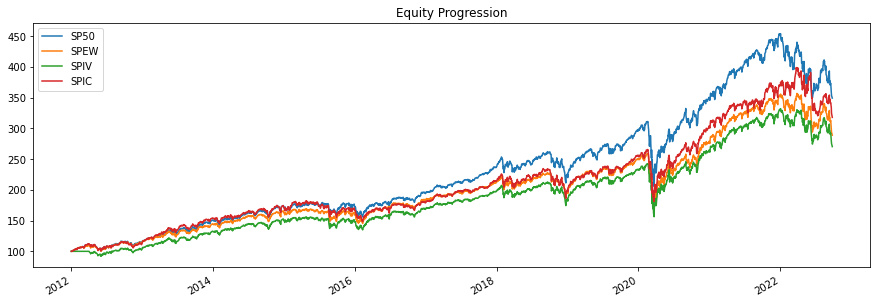

In [17]:
backtest_sp50 = bt_passive_equal('SP50',['IVV'],prices)
backtest_spew = bt_passive_equal('SPEW',tickers,prices)
backtest_spiv = bt_passive_vol('SPIV',tickers,prices)
backtest_spic = backtest_InvestmentClock('SPIC',tickers,prices,signals, cuts={'GDP':2.5,'CPI':4.0})


report = bt.run(backtest_sp50, backtest_spew, backtest_spiv, backtest_spic)
report.set_riskfree_rate(0.05)
report.plot()
report.display()

### Use KNN to determine the best performing strategies for the current economic regime.

##### With a performance history of different risk premia strategies, I can identify which strategie could be best to adopt for the current ecnomic regime.

In [166]:
### Excerpt from Cluster Analysis paper explaining what I aim to do in the next section. ###

# For each of these K nearest neigbours, we find the average return over a succeeding quarter for all risk premia factors.
# We rank these factors according to their average returns, and choose a subset S that performed the best.

# If we set S = 1, it is equivalent to finding the best performing strategy historically in the same macro regime. 
# If we set S = 20, we will get an equal weighted strategy over the 20 risk premia.
# If we set k = 1, we choose the nearest instance and replicate that for the current month.
# If we set k = 40, then we take all months in the input sample and average out the results, and invest in the best S strategies.

In [167]:
# For each date, choose the strategy that worked the best for the subsequent quarter. (S >= 1).
# To get the performance of each strategy, I take the difference between the current quarters start and the next quarters start.
# From these gains, I determine the S best strategies performed.

# K is defined in the KNN Section of Code.
# (Note the returns of each strategy is dependent on the pd.DateOffset function. I choose the nearest date to 4 months in advance
# to represent the returns after a quarter's duration.)

S = 2
winners = list()
count = 0
for date in nearest_neighbours.index:
    current_vals = report.prices[report.prices.index == date]
#    print(current_vals)

    next_vals = report.prices.iloc[report.prices.index.get_indexer([date + pd.DateOffset(months = 4)], method='nearest')]
#    print(next_vals)

    scores = next_vals.sub(current_vals.values, axis = 1)
#    print("Scores: ", scores.values[0])

    if count == 0:
        chosen = scores.transpose().nlargest(S, columns=scores.transpose().columns[0]).transpose()
        count += 1
    else:
        chosen = pd.concat([chosen, scores.transpose().nlargest(S, columns=scores.transpose().columns[0]).transpose()])
#    print()

print("The ", S ," best returns of the considered strategies from each of the ", K, " nearest neighbour economic regimes are:")
chosen

The  2  best returns of the considered strategies from each of the  5  nearest neighbour economic regimes are:


,SPIC,SP50,SPIV,SPEW
2022-09-27,-11.300915,-11.741074,NaN,NaN
2022-08-01,NaN,NaN,-22.487764,-26.692647
2022-04-29,-3.528918,NaN,-25.069963,NaN
2019-04-30,NaN,40.767090,NaN,33.054260
2017-07-31,9.719005,10.663533,NaN,NaN


### Next Section:
##### How could one now tranlsate this knowledge into a recommended strategy for the current economic regime?